In [3]:
import pickle as pkl
import numpy as np
with open('data/filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)

In [4]:
from visual_utils import *

In [4]:
def draw_feat_map(feat, color, ax):
    for r in range(19):
        for c in range(19):
            if feat[r][c]:
                ax.plot(r, c, 'X', markersize=10, markerfacecolor=color)

### simple eye

In [6]:
def eyes(own, opp):
    feat_map = np.zeros(own.shape)
    for r in range(19):
        for c in range(19):
            if (r == 0 or own[r-1][c]) \
                and (r == 18 or own[r+1][c]) \
                and (c == 0 or own[r][c-1]) \
                and (c == 18 or own[r][c+1]) \
                and (not own[r][c] and not opp[r][c]):
                feat_map[r][c] = 1
    return feat_map
        
def opp_eyes(own, opp):
    return eyes(opp, own)

### 4-wall

In [3]:
def walls(own, opp, minlen=4):
    feat_map = np.zeros(own.shape)
    for r in range(19):
        cont = 0
        for c in range(19):
            if own[r][c]:
                cont += 1
            else:
                cont = 0
            if cont == minlen:
                for i in range(minlen):
                    feat_map[r][c-i] = 1
            elif cont > minlen:
                feat_map[r][c] = 1
    for c in range(19):
        cont = 0
        for r in range(19):
            if own[r][c]:
                cont += 1
            else:
                cont = 0
            if cont == minlen:
                for i in range(minlen):
                    feat_map[r-i][c] = 1
            elif cont > minlen:
                feat_map[r][c] = 1
    return feat_map

def opp_walls(own, opp, minlen=4):
    return walls(opp, own, minlen)

<AxesSubplot:>

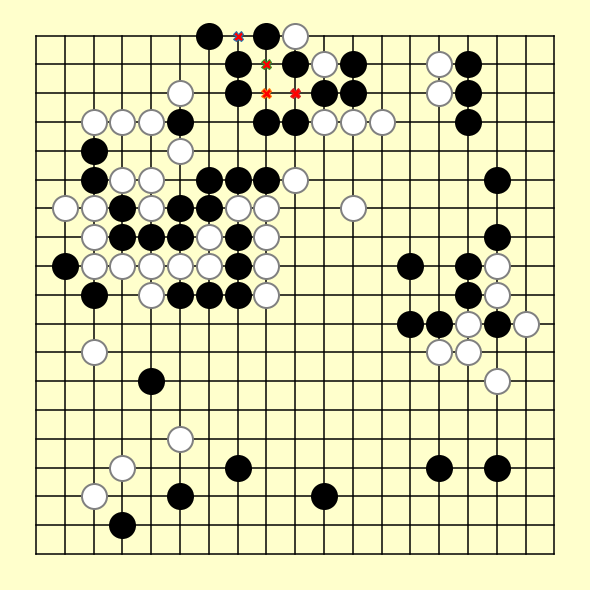

In [51]:
def is_surrounded(own, opp, i, j):
    marked = np.zeros((19, 19))
    if _is_surrounded(own, opp, i, j, marked):
        return marked
    else:
        return None

def _is_surrounded(own, opp, i, j, marked):
    if marked[i][j]:
        return True
    if opp[i][j]:
        return False
    if own[i][j]:
        return True
    marked[i][j] = 1
    adj_list = ((i+1, j), (i-1, j), (i, j-1), (i, j+1))
    for adj in adj_list:
        if adj[0] < 0 or adj[0] > 18 or adj[1] < 0 or adj[1] > 18:
            continue
        if not _is_surrounded(own, opp, adj[0], adj[1], marked):
            return False
    return True

def mark_surrounded(own, opp):
    marked = np.zeros((19, 19))
    for i in range(19):
        for j in range(19):
            if not marked[i][j]:
                group = is_surrounded(own, opp, i, j)
                if group is not None:
                    marked += group
    return marked

b_board, w_board = annotations[2000]['board_state']
m = mark_surrounded(b_board, w_board)
draw_go_board(b_board, w_board, m)

alive stones (own/opp), last move, territory if you can figure that out (or just change of ownership)

implement benson's algorithm

IndexError: list index out of range

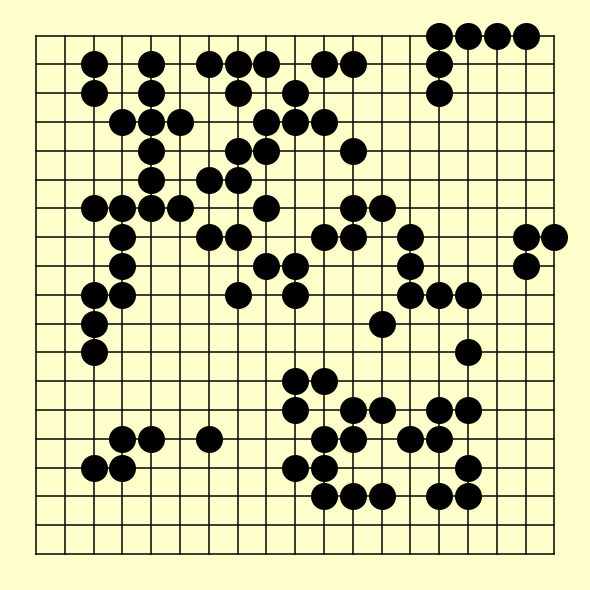

In [31]:
def same_color_region(board, i, j, stone_set, adj_set, marked):
    if marked[i][j] == 1:
        return
    marked[i][j] = 1
    stone_set.add((i, j))
    adj_list = ((i+1, j), (i-1, j), (i, j-1), (i, j+1))
    for adj in adj_list:
        if adj[0] < 0 or adj[0] > 18 or adj[1] < 0 or adj[1] > 18:
            continue
        adj_set.add(adj)
        if board[adj[0]][adj[1]] == board[i][j]:
            same_color_region(board, adj[0], adj[1], stone_set, adj_set, marked)
        
def set_to_feat_map(stone_set):
    feat_map = np.zeros((19, 19))
    for i, j in stone_set:
        feat_map[i][j] = 1
    return feat_map

def benson_alive(board):
    X, R = [], []
    marked = np.zeros((19, 19))
    for i in range(19):
        for j in range(19):
            if marked[i][j]:
                continue
            s, a = set(), set()
            same_color_region(board, i, j, s, a, marked)
            if board[i][j]:
                X.append((s, a))
            else:
                if len(s) < 50:
                    R.append((s, a))
                    
    
    for xi, (x, x_adj) in enumerate(X):
        adj_r_count = 0
        for r, r_adj in R:
            for r, c in x:
                if (r, c) in r_adj:
                    adj_r_count += 1
                    break
        if adj_r_count < 2:
            X.remove()
    return X, R
    
X, R = benson_alive(b_board)
ax = draw_go_board(b_board, np.zeros((19, 19)))
draw_feat_map(set_to_feat_map(R[2][0]), 'r', ax)

<AxesSubplot:>

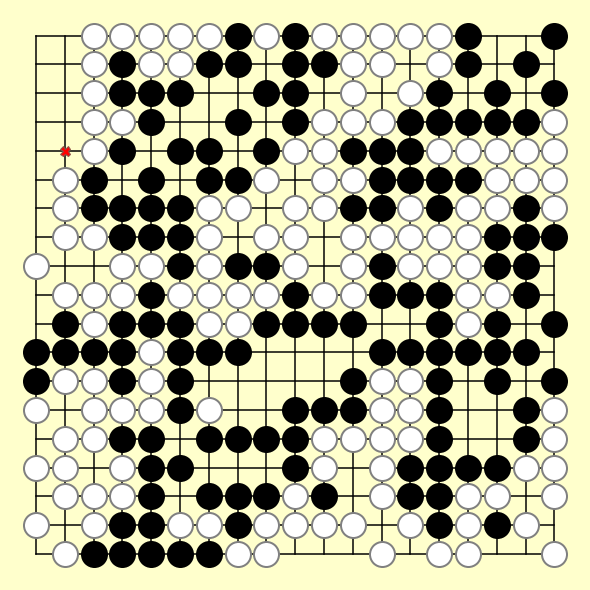

In [60]:

def set_to_feat_map(stone_set):
    feat_map = np.zeros((19, 19))
    for i, j in stone_set:
        feat_map[i][j] = 1
    return feat_map

def cuts(own, opp):
    
    def same_color_region(board, opp, i, j, stone_set, adj_set, marked):
        if marked[i][j] == 1:
            return
        marked[i][j] = 1
        stone_set.add((i, j))
        adj_list = ((i+1, j), (i-1, j), (i, j-1), (i, j+1))
        for adj in adj_list:
            if adj[0] < 0 or adj[0] > 18 or adj[1] < 0 or adj[1] > 18:
                continue
            if not board[adj[0]][adj[1]] and not opp[adj[0]][adj[1]]:
                adj_set.add(adj)
            if board[adj[0]][adj[1]] == board[i][j]:
                same_color_region(board, opp, adj[0], adj[1], stone_set, adj_set, marked)

    
    marked = np.zeros((19, 19))
    X = []
    marked = np.zeros((19, 19))
    for i in range(19):
        for j in range(19):
            if marked[i][j]:
                continue
            if opp[i][j]:
                s, a = set(), set()
                same_color_region(opp, own, i, j, s, a, marked)
                X.append((s, a))
    C = set()
    for ai, (s, a) in enumerate(X):
        for a2i, (s2, a2) in enumerate(X):
            if ai == a2i:
                continue
            if len(s) + len(s2) < 3:
                continue
            inter = set.intersection(a, a2)
            if len(inter) == 1:
                for r, c in inter:
                    libs = 0
                    if r > 0 and not opp[r-1][c]:
                        libs += 1
                    if r < 18 and not opp[r+1][c]:
                        libs += 1
                    if c > 0 and not opp[r][c-1]:
                        libs += 1
                    if c < 18 and not opp[r][c+1]:
                        libs += 1
                    if libs >= 2:
                        C.add((r, c))
    ft = np.zeros((19, 19))
    for i, j in C:
        if not own[i][j] and not opp[i][j]:
            ft[i][j] = 1
    return ft
    
            
import pickle as pkl
import numpy as np
from visual_utils import *
with open('data/filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)
import random
k = int(random.random() * len(annotations))
b_board, w_board = annotations[k]['board_state']
draw_go_board(b_board, w_board, cuts(b_board, w_board))

### play that continues winning/losing ladder. 
#### play on the singular liberty of a stone that creates two liberties
#### once you find this, zig zag until breaker / dead end

930


<AxesSubplot:>

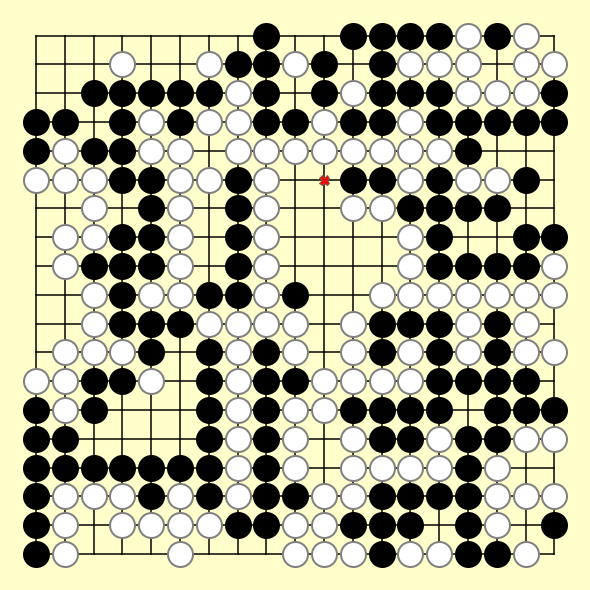

In [11]:
from dlgo import goboard_fast as goboard
from dlgo.gotypes import Point, Player
from dlgo.encoders.sevenplane import SevenPlaneEncoder
from dlgo.gosgf.sgf_properties import interpret_go_point

def get_seven_planes(sgf_str):
    game = goboard.GameState.new_game(19)        
    move_seq = sgf_str.split(';')[1:-1]
    for move_name in move_seq:
        idx = move_name.index('[')
        col_s, row_s = move_name[idx+1], move_name[idx+2]
        col = ord(col_s) - 97
        row = 19 - ord(row_s) + 96
        if 'B' in move_name:
            game.board.place_stone(Player.black, Point(row+1, col+1))
        elif 'W' in move_name:
            game.board.place_stone(Player.white, Point(row+1, col+1))
    encoder = SevenPlaneEncoder((19, 19))
    svp = encoder.encode(game)
    ones = np.ones((1, 19, 19))
    return np.concatenate((svp, ones), axis=0)

def in_grid(i, j):
    return 0<=i<19 and 0<=j<19

def ladders(svp):
    own = np.sum(svp[0:3], axis=0)
    opp = np.sum(svp[3:6], axis=0)
    ft = np.zeros((19, 19))
    for i in range(1, 18):
        for j in range(1, 18):
            if own[i][j] or opp[i][j]:
                continue
            continues_ladder = False
            libs = 0
            owns = 0
            adjs = ((i-1, j), (i+1, j), (i, j-1), (i, j+1))
            for r, c in adjs:
                if not in_grid(r, c):
                    continue
                if not own[r][c] and not opp[r][c]:
                    libs += 1
                if own[r][c]:
                    owns += 1
                if svp[0][r][c]:
                    continues_ladder = True
            if continues_ladder and libs == 2 and owns==1:
                if ladder_breaks(svp, i, j):
                    ft[i][j] = 1
                else:
                    ft[i][j] = 2
    return ft

def zigzag(own, opp, i, j, step1, step2):
    r, c = i, j
    s = 1
    step = step2
    otherstep = step1
    while in_grid(r, c):
        if opp[r][c]:
            return False
        if own[r][c]:
            return True
        if not in_grid(r+step[0], c+step[1]) or opp[r+step[0]][c+step[1]]:
            return False
        if in_grid(r+step[0], c+step[1]) and own[r+step[0]][c+step[1]]:
            return True
        #cutting ladder breaker
        if in_grid(r+step[0]-otherstep[0], c+step[1]-otherstep[1]) and own[r+step[0]-otherstep[0]][c+step[1]-otherstep[1]]:
            if not in_grid(r-2*otherstep[0], c-2*otherstep[1]) or not opp[r-2*otherstep[0]][c-2*otherstep[1]]:
                return True
        if s % 2 == 0:
            step = step1
            otherstep = step2
        else:
            step = step2
            otherstep = step1
        r += step[0]
        c += step[1]
        s += 1
    return False
 
def ladder_breaks(svp, i, j):
    own = np.sum(svp[0:3], axis=0)
    opp = np.sum(svp[3:6], axis=0)
    
    #in grid
    if in_grid(i-1, j) and own[i-1][j]:
        step1 = (1, 0)
    elif in_grid(i+1, j) and own[i+1][j]:
        step1 = (-1, 0)
    elif in_grid(i, j-1) and own[i][j-1]:
        step1 = (0, 1)
    elif in_grid(i, j+1) and own[i][j+1]:
        step1 = (0, -1)
    
    if not in_grid(i-1, j) or opp[i-1][j]:
        step2 = (1, 0)
    elif not in_grid(i+1, j) or opp[i+1][j]:
        step2 = (-1, 0)
    elif not in_grid(i, j-1) or opp[i][j-1]:
        step2 = (0, 1)
    elif not in_grid(i, j+1) or opp[i][j+1]:
        step2 = (0, -1)
    
    #special case where you can zigzag both ways
    if step1[0] == -step2[0] and step1[1] == -step2[1]:
        zz1 = zigzag(own, opp, i, j, step1, (step1[1], step1[0]))
        zz2 = zigzag(own, opp, i, j, step1, (-step1[1], -step1[0]))
        return zz1 or zz2
    else:
        return zigzag(own, opp, i, j, step1, step2)
    
import pickle as pkl
import numpy as np
from visual_utils import *
import random


ki = int(random.random()*len(ls))
print(ki)
svp = get_seven_planes(annotations[ls[ki]]['sgf'])
own = np.sum(svp[0:3], axis=0)
opp = np.sum(svp[3:6], axis=0)
ft = ladders(svp)

draw_go_board(own, opp, ft)    

In [5]:
ls = set()
for i in range(10000):
    svp = get_seven_planes(annotations[i]['sgf'])
    own = np.sum(svp[0:3], axis=0)
    opp = np.sum(svp[3:6], axis=0)
    ft = ladders(svp)
    for r in range(19):
        for c in range(19):
            if ft[r][c]:
                ls.add(i)


In [6]:
ls = list(ls)

<AxesSubplot:>

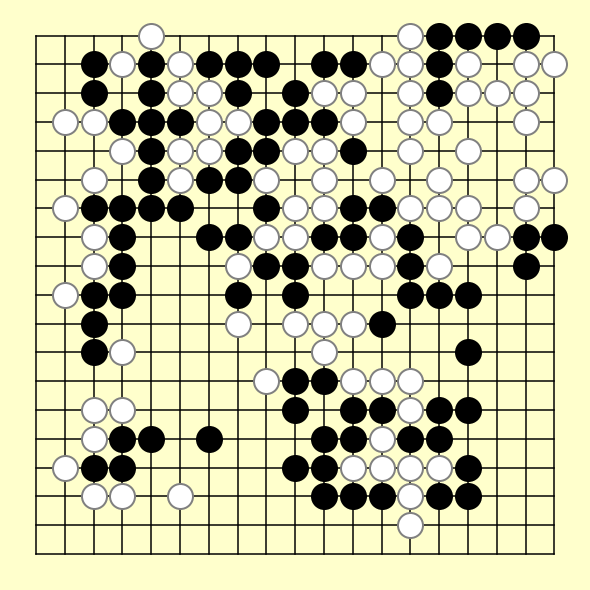

In [14]:
b_board, w_board = annotations[1342]['board_state']
draw_go_board(b_board, w_board, None)

In [18]:
is_surrounded(w_board, b_board, 3, 18)

False

In [ ]:
ladder_mask = np.zeros((5, 5))